In [1]:
#General imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
plt.rcParams["animation.html"] = "jshtml"

#FINESSE specific imports
import finesse
import finesse.components as fc
import finesse.analysis.actions as fac
import finesse.detectors as fd

#Imports for silly plotting
try:
    import wesanderson   #color palettes from wes anderson movies
    from cycler import cycler #matplotlib cycler
    colors = wesanderson.film_palette('darjeeling') + wesanderson.film_palette('rushmore')
    default_cycler = (cycler(color=colors) +
                  cycler(linestyle=['-',(0, (1, 1)),(0, (5, 1)),(5, (10, 3)),(0, (5, 10)),        
                                    (0, (5, 5)),(0, (1, 5)),(0, (3, 10, 1, 10)),(0, (3, 5, 1, 5)),
                                    (0, (3, 1, 1, 1))])) #parameterized linestyles. do not ask.
    plt.rc('axes', prop_cycle=default_cycler)
    plt.rc('font', **{'family': 'serif'})

except ImportError as e:
    import matplotlib.colors as mcolors
    colors = mcolors.BASE_COLORS #use default mplotlib colors (boring)
    default_cycler = (cycler(color=colors) + cycler(linestyle = ['-',(0, (1, 1)),(0, (5, 1)),(5, (10, 3)),(0, (5, 10)),        
                                    (0, (5, 5)),(0, (1, 5)),(0, (3, 10, 1, 10)),(0, (3, 5, 1, 5)),
                                    (0, (3, 1, 1, 1))]))
    plt.rc('axes', prop_cycle=default_cycler)
    plt.rc('font', **{'family': 'serif'})
    print("passed")
    pass  # don't have libraries installed     

# Contents
* [Introduction](#zeroth-bullet)
* [Syntax Reference](#first-bullet) 
* [Building the Model](#second-bullet) 
    * [Tracing the Cavity](#third-bullet) 
* [Example: Imperfect Mode-Matching](#fourth-bullet)
* [Challenge: Misalignment](#fifth-bullet)

## Introduction <a class="anchor" id="zeroth-bullet"></a>

In this notebook, we'll explore how higher-order Hermite-Gauss modes are implemented in FINESSE, and how you can use them in your models to study complex optical interferometers.

First off, why would we want to do this? As we saw in the previous session and earlier today, the plane-waves model was already quite powerful, allowing us to accurately model even the rather complex PDH locking scheme. 

However, real interferometers are imperfect. For instance, a beam coupled into a cavity might be misaligned with respect to the cavity axis, or the beam might be improperly mode-matched. In order to model these imperfections, we have to consider beam properties transverse to the optical axis. One way to accomplish this is via an expansion into the orthonormal basis of Hermite-Gauss modes.

We aren't going to explore the math behind the Hermite-Gauss modes (as solutions to the par-axial wave equation), nor how FINESSE determines the amount of power in these modes given some arbitrary system (through scattering matrices). This is all quite math heavy, and there are sources that could explain it infinitely better than I can. If you're interested in the finer points of HOMs in general I'll point you to the <a href="https://link.springer.com/article/10.1007/s41114-016-0002-8#Sec1">living review</a> article, and if you're interested in how FINESSE implements these you should check the <a href="https://finesse.ifosim.org/docs/develop/physics/higher_order_modes/index.html">docs</a> or this old <a href="https://www.gwoptics.org/finesse/download/old/Finesse-0.98.pdf#page=55.30">FINESSE manual</a>.

## Syntax Reference <a class="anchor" id="first-bullet"></a>

1) **link** <a class="anchor" id="link"></a> - Generates spaces of arbitrary length between components. Names of spaces are autogenerated. 

        model.link(component: str, length: float, verbose = False: bool)

    To link multiple components, specify components in order with lengths between. For example, to link a laser to a mirror with 1m between them, you could use:

        model.link(laser, 1, mirror, verbose = True)

    The verbose flag controls whether FINESSE will print out a list of the connections it has made.

2) **mismatches_table** <a class="anchor" id="mmtab"></a> - Displays mismatches present in model as a table. 

        model.mismatches_table(ignore_AR = True: bool, numfmt='{:.4f}': str)
    
    The mismatch between two beam parameters in FINESSE is defined as:
    $
       M = \frac{|q_1 - q_2|^2}{|q_1 - q^{*}_2|^2}, \ M\in[0,1].
    $
    The ignore_AR flag specifies whether FINESSE should ignore reflection mismatch for surfaces with R=0. numfmt arg allows you to specify how you want the number printed, following standard python formatting options. The default is a floating point number rounded to 4 decimal places.
3) **gauss** <a class="anchor" id="gauss"></a> - Manually specify a beam parameter at a certain node.
    
        model.add(fc.Gauss("name", node, *args))

    The beam parameter *args can be specified in multiple different ways. For instance, if you knew q, you could use:

        model.add(fc.Gauss("name", node, q=q))

    You can also use: w0, z, zR, etc. For a full summary of legal initializations see: <a href="https://finesse.ifosim.org/docs/develop/api/components/gauss/finesse.components.gauss.Gauss.html#finesse.components.gauss.Gauss">FINESSE Docs</a>

4) **modes** <a class="anchor" id="modes"></a> - Specify which TEM modes FINESSE should include in simulation.

        model.modes(modes = None: list or str, maxtem = None: int, include = None: list, remove = None: list)

    maxtem arg should be an integer corresponding to the maximum mode order to be included in the model. The modes/include/remove args can be iterables which can be unpacked into two integer values (one for each mode index), i.e if you wanted to model using only the [0,0], [2,0], and [0,2] modes, you could use

        model.modes(modes = [[0,0],[2,0],[0,2]])

    The modes arg can additionally be a str, either 'even'/'odd' or 'x'/'y' to finetune which modes you want to model with.
5) **CCD** <a class="anchor" id="ccd"></a> - Detects transverse intensity profile of a beam at a specified node.

        model.add(fd.CCD(name, node, xlim, ylim, npts, w0_scaled = True))
        
    x/ylim specifies dimensions of image (in meters). If only a single value (x) is passed to either, the limits will be $[-|x|,|x|]$. The number of pixels in the image is defined with npts. If w0_scaled is true, FINESSE automatically scales the image dimensions to the beam waist size.
    

## Building the Model <a class="anchor" id="second-bullet"></a>

We'll start by rebuilding our simple Fabry-Perot cavity. A quick doodle of the cavity (below) shows that we'll need: a laser, two mirrors, and spaces to connect them.

In [2]:
# Cavity 
#                          /--\                   /--\
#                  M1.p1.i |  | M1.p2.o   M2.p1.i |  | M2.p2.o
#        .-------.     --->|  |--->           --->|  |--->
#        |Laser  |--->     |M1|                   |M2|
#        `-------'     <---|  |<---           <---|  |<---
#                  M1.p1.o |  | M1.p2.i   M2.p1.o |  | M2.p2.i
#                          \--/                   \--/

In [3]:
model = finesse.Model()

### Sources ###
laser = model.add(fc.Laser("Laser", P = 1, phase = 0))

### Mirrors ###
m1 = model.add(fc.Mirror("M1", R = 0.9, T = 0.1, Rc = -2))
m2 = model.add(fc.Mirror("M2", R = 0.9, T = 0.1, Rc = 2))



In the previous session, we defined individual space components. This will certainly do it, but if you don't really care about what the spaces are called (which you often won't) then you can have FINESSE automatically populate your model with spaces, which is faster and less verbose. There are a few commands to do this, but I'll use [**link**](#link).

In [4]:
### Spaces ###
model.link(laser,0,m1,1,m2, verbose = True) #verbose = True means FINESSE will print the connections it makes

Connecting Laser to M1
Selecting port <Port Laser.p1 Type=NodeType.OPTICAL @ 0x10514f910> for <'Laser' @ 0x14b9b0d10 (Laser)>
Selecting port <Port M1.p1 Type=NodeType.OPTICAL @ 0x14b9a7850> for <'M1' @ 0x14a014f10 (Mirror)>
Connecting M1 to M2
Selecting port <Port M1.p2 Type=NodeType.OPTICAL @ 0x14d430190> for <'M1' @ 0x14a014f10 (Mirror)>
Selecting port <Port M2.p1 Type=NodeType.OPTICAL @ 0x14d432a50> for <'M2' @ 0x14d432150 (Mirror)>


In [5]:
#Finally, we define our cavity, and add some power detectors

### Cavity ###
cav = model.add(fc.Cavity("cav", m1.p2.o, m2.p1.o))  #source - m1.p2.o, via - m2.p1.o

### Detectors ###
trans = model.add(fd.PowerDetector("Trans", m2.p2.o))
refl = model.add(fd.PowerDetector("Refl", m1.p1.o))
circ = model.add(fd.PowerDetector("Circ", m2.p1.o))

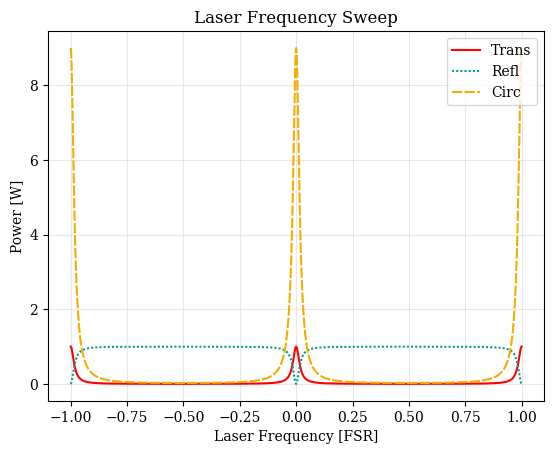

In [6]:
# Just to check, let's run a quick simulation sweeping over the laser frequency. 

sol = model.run(fac.Xaxis(laser.f,"lin",-cav.FSR,cav.FSR,1000)) #cav.FSR -> cavity free spectral range in Hz

x1 = sol.x1/cav.FSR #normalize x-axis to cavity FSR
plt.figure()
plt.plot(x1,sol["Trans"],label='Trans'),plt.plot(x1,sol["Refl"],label='Refl'),plt.plot(x1,sol["Circ"],label='Circ')
plt.grid(alpha=0.3), plt.ylabel('Power [W]'), plt.xlabel('Laser Frequency [FSR]'), plt.title('Laser Frequency Sweep')
plt.legend(fontsize=10,loc='upper right');

## Tracing the Cavity <a class="anchor" id="third-bullet"></a>

In [7]:
prop_cav = model.propagate_beam(from_node = m1.p2.o, to_node = m2.p1.i) #Beam propagation through our cavity

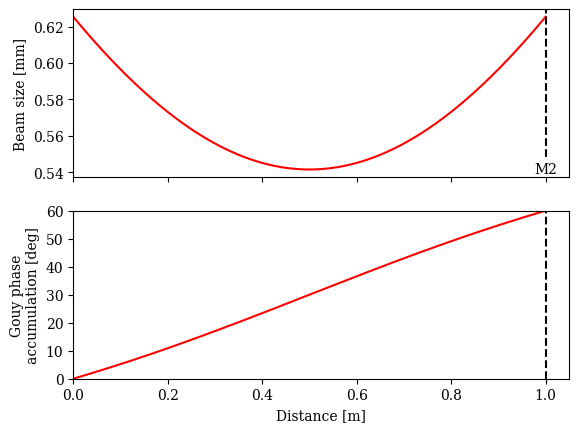

In [8]:
prop_cav.plot(); #in-built FINESSE plotting func.

In [9]:
# Alternatively, we can display this information as a table
prop_cav.table()

In [10]:
# Now, we can look at the cavity eigenmode and round-trip gouy phase accumulation
print("Cavity Beam Param: ", cav.q[0])
print("Cavity Round-Trip Gouy Phase (x,y): ",cav.gouy)

Cavity Beam Param:  BeamParam(w0=541.58 um, z=-500 mm, w=625.36 um, Rc=-2 m)
Cavity Round-Trip Gouy Phase (x,y):  [120. 120.]


## Example: Imperfect Mode-Matching <a class="anchor" id="fourth-bullet"></a>

Now that we have our model, let's look at a situation where you'd need to include higher-order modes.



Without a beam parameter specified at some node FINESSE will simply trace the eigenmode of the cavity throughout the model. Since we aren't yet specifying any beam parameters, our model will be perfectly mode-matched, which we can check using the method [**mismatches_table**](#mmtab).

In [11]:
print(model.mismatches_table()) #Empty table means no mismatches present.

┌──────────╥──────────────┬──────────────┐
│ Coupling ║ Mismatch (x) │ Mismatch (y) │
└──────────╨──────────────┴──────────────┘



Now, say we had this cavity in the lab and we wanted to mode-match a beam into it. We go off to JaMMt and plug away until we find a mode-matching solution. Once we do, we steal the necessary lenses from a neighboring lab, put them on the table, and, oh no! Our mode-matching solution is off! We wanted a beam radius of 541.58 $\mu m$ 500mm into the cavity, but instead our solution gave us a 500 $\mu m$ beam 300mm into the cavity. How can we model this in FINESSE? 

One possible way is using the [**gauss**](#gauss) command, which lets you specify the beam parameter at any node in your model:

In [12]:
gauss_bp = model.add(fc.Gauss("gauss", node = m1.p1.i, w0 = 80/1e6, z = -200/1e3))

The sign convention here is a little confusing. z (position of node relative to waist) is negative if the beam is *converging* to the waist, and positive if it is *diverging*.

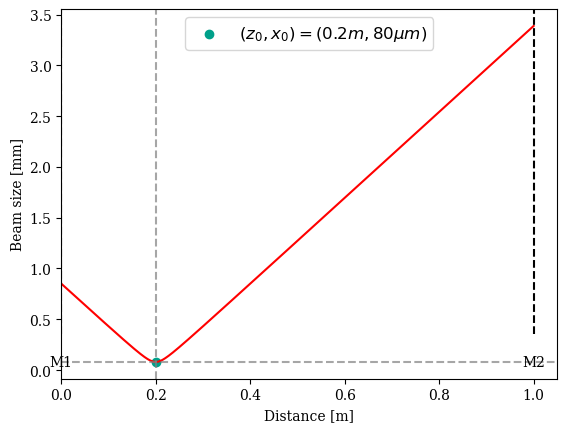

In [13]:
#By propagating the beam like we did earlier, we can verify that our gauss command is working.
#We do see a waist 300mm inside the cavity, with the proper waist size
prop_cav_mismatch = model.propagate_beam(from_node = m1.p1.i, to_node = m2.p1.i)
prop_cav_mismatch.plot_beamsizes(); #plot only beam size, we just want to make sure the waist is in the right place
plt.axvline(0.2,0,1,color='grey',linestyle='dashed',alpha=0.7), plt.axhline(0.08,0,1,color='grey',linestyle='dashed',alpha=0.7)
plt.scatter(0.2,0.08,color=colors[1],label=r'$(z_0,x_0) = (0.2m, 80\mu m)$')
plt.legend(fontsize=12)

We'll also have to specify which TEM modes we want FINESSE to include in any simulations. This is done using the [**modes**](#modes) command:

In [14]:
model.modes(maxtem=3) #use all modes up to order 3
model.homs #model.homs prints modes included in model. Use to check model.modes().

array([[0, 0],
       [1, 0],
       [0, 1],
       [2, 0],
       [1, 1],
       [0, 2],
       [3, 0],
       [2, 1],
       [1, 2],
       [0, 3]], dtype=int32)

In [15]:
#Now we can check for mismatches again
print(model.mismatches_table())

┌────────────────────╥──────────────┬──────────────┐
│      Coupling      ║ Mismatch (x) │ Mismatch (y) │
╞════════════════════╬══════════════╪══════════════╡
│ M1.p1.i -> M1.p2.o ║       0.9250 │       0.9250 │
├────────────────────╫──────────────┼──────────────┤
│ M1.p1.i -> M1.p1.o ║       0.9891 │       0.9891 │
├────────────────────╫──────────────┼──────────────┤
│ M1.p2.i -> M1.p1.o ║       0.9250 │       0.9250 │
└────────────────────╨──────────────┴──────────────┘



This table deserves some explanation. FINESSE defines the mismatch between two beam parameters as:
\begin{equation}
    M = \frac{|q_1 - q_2|^2}{|q_1-q^*_2|^2}
\end{equation}
As you can check for yourself, this implies that $M\in [0,1]$. We see from the first row of the table that between the beam parameter at M1.p1.i and the new beam parameter at M1.p2.o, there is a 92.5% mismatch. In order to verify this, we simply extract the q parameter at these nodes from our model using the following syntax:

In [16]:
q_in = gauss_bp.qx.q #returns the beam parameter in the x-direction associated with the gauss command as a complex number
q_out = cav.qx.q     #cavity eigenmode beam parameter

#x or y direction does not matter here, as our cavity is non-astigmatic.

M = np.abs(q_in - q_out)**2/np.abs(q_in - np.conj(q_out))**2 #definition of mismatch
print("Mismatch: ", np.round(M,3))

#Just as we expect from the table!

Mismatch:  0.925


Let's see what the transmitted power looks like now that we have imperfect mode-matching. I'll use amplitude detectors to detect the light-field amplitudes of particular TEM modes. In the case of imperfect mode-matching, we expect coupling into modes of order: $\space$ $m+n = 2$.

In [17]:
ad20 = model.add(fd.AmplitudeDetector("ad20", m2.p2.o, f = 0, n = 2, m = 0))
ad02 = model.add(fd.AmplitudeDetector("ad02", m2.p2.o, f = 0, n = 0, m = 2))
ad11 = model.add(fd.AmplitudeDetector("ad11", m2.p2.o, f = 0, n = 1, m = 1))

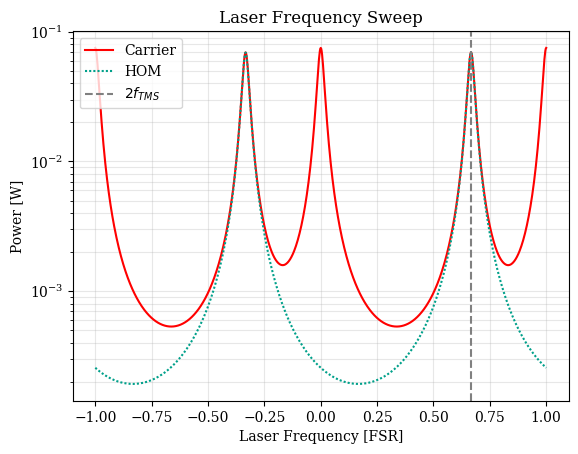

In [18]:
#Now, what if we again swept over the laser frequency and plotted the transmitted power

mismatch_sol = model.run(fac.Xaxis(laser.f,"lin",-cav.FSR,cav.FSR,1000))

#We can determine the total power in the m+n = 2 mode order by summing (in quadrature) the contributions of each
#amplitude detector

power_in_HOM = np.abs(mismatch_sol["ad20"])**2 + np.abs(mismatch_sol["ad02"])**2 + np.abs(mismatch_sol["ad11"])**2 

x1 = mismatch_sol.x1/cav.FSR
plt.figure()
plt.semilogy(x1,mismatch_sol["Trans"],label='Carrier'), plt.semilogy(x1,power_in_HOM,label=r'HOM')
plt.grid(alpha=0.3,which='both'), plt.ylabel('Power [W]'), plt.xlabel('Laser Frequency [FSR]'), plt.title('Laser Frequency Sweep')
plt.axvline(2*cav.mode_separation[0]/cav.FSR,0,1,label=r'$2f_{TMS}$',color='grey',linestyle='dashed');
plt.legend(fontsize=10,loc='upper left');

This plot is cool, but we can get cooler. We'll use a new detector called a [**CCD**](#ccd), which measures the intensity profile of our beam as a function of the transverse coordinates: $I = |E(x,y)|^2$. We'll use this to scan our laser's frequency over the 2nd order HOM resonance to see their transmission, just as you would in the lab.

In [19]:
#Add CCD to model
ccd = model.add(fd.CCD("ccd", m2.p2.o, xlim = 2.5, ylim = 2.5, npts = 80))

#Sweep over laser frequency
ccd_sol = model.run(fac.Xaxis(laser.f,"lin", -cav.FSR, cav.FSR, 100))

In [20]:
#### THIS TAKES A WHILE TO RUN BE WARNED

fig, (axi,axl) = plt.subplots(ncols = 2,layout='tight',width_ratios=[3,3]) #define plot

fig.suptitle('Laser Frequency Scan')
frames = [] #list of frames
im = axi.imshow(ccd_sol["ccd"][0])
for i in range(ccd_sol["ccd"].shape[0]):  #iterate over CCD frames
    im = axi.imshow(ccd_sol["ccd"][i], animated = True, cmap='magma', aspect='equal', vmin = 0, vmax = np.max(ccd_sol["ccd"][0])) #define "artist"
    pl, = axl.plot(ccd_sol.x1[:i]/cav.FSR,ccd_sol["Trans"][:i], color=colors[1], linestyle='-')
    do = axl.scatter(ccd_sol.x1[:i]/cav.FSR, ccd_sol["Trans"][:i], color=colors[4], marker='d') 
    frames.append([im, pl, do]) #append to list of frames
axi.set_ylabel('Pixels')
axi.set_xlabel('Pixels')

axl.set_xlabel('Frequency [FSR]')
axl.set_ylabel('Power [W]')
axl.set_yscale('log')
axl.grid(alpha=0.3,which='both')
plt.close()
ani = animation.ArtistAnimation(fig, frames, interval=100,
                                blit=True)
ani

In [ ]:
### I'll remove the Gauss command so FINESSE will go back to using the cavity eigenmode as its starting beam parameter.
model.remove('gauss') #Test

KeyError: 'gauss'

## Challenge: Misalignment <a class="anchor" id="fourth-bullet"></a>

Now that we've used higher-order modes to model mode-mismatch in a simple cavity, I'd like you to use the same principles in order to model misalignment to the cavity axis. 

In order to do this, you should add a mirror between the laser and the input mirror of the cavity. Recall the way we do this:

        model.add(fc.Mirror("name",R, T, L, xbeta, ybeta))

Note, the mirror has two additional arguments xbeta and ybeta that we haven't yet discussed. xbeta and ybeta correspond to misalignments in the yaw and pitch directions (respectively) in units of radians. 

Add a small misalignment in either direction, and complete the following tasks:
1) Print the mismatches table. 

2) Using two new amplitude detectors (which modes should they detect?) produce a plot of the transmitted *power* as a function of laser frequency.

3) Verify that the additional resonance peaks you see occur at the transverse mode spacing frequency, which you can get using **cav.mode_separation[0]**.

4) Bonus: Using a CCD, show an animation of the beam transmitted from the cavity as you vary the frequency (note: if you don't want your laptop to explode, you need to use a relatively small number of steps in your simulation).